In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             accuracy_score, recall_score, f1_score)
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset


import warnings
warnings.filterwarnings('ignore')

In [2]:
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [3]:
def data_quality_check(df):
    data_quality_stats = []

    for col in df.columns:
        data_type = df[col].dtype
        missing_values = df[col].isnull().sum()
        missing_values_pct = round(100*missing_values/df.shape[0], 2)
        unique_values_num = df[col].nunique()
        if pd.api.types.is_numeric_dtype(df[col]):
            min_value = df[col].min()
            max_value = df[col].max()
            mean_value = df[col].mean().round(2)
            median_value = df[col].median()
            mode_value = df[col].mode()[0] if not df[col].mode().empty else None
            mode_pct = (df[col] == mode_value).mean()*100 if mode_value is not None else None
            std_dev = df[col].std()
            quantile_25 = df[col].quantile(0.25)
            quantile_50 = df[col].quantile(0.50) 
            quantile_75 = df[col].quantile(0.75)
        else: 
            min_value = None
            max_value = None
            mean_value =  None
            median_value = None
            mode_value = df[col].mode()[0] if not df[col].mode().empty else None
            mode_pct = (df[col] == mode_value).mean()*100 if mode_value is not None else None
            std_dev = None
            quantile_25 = None
            quantile_50 = None
            quantile_75 = None

        data_quality_stats.append({
        'Column Name' : col, 
        'Data Type' : data_type, 
        'Number of Missing Values' : missing_values, 
        '% of Missing values' : missing_values_pct, 
        'Number of Unique Values' : unique_values_num,
        'Minimum Value' : min_value,
        'Maximum Value' : max_value,
        'Mean' : mean_value, 
        'Median' : median_value,
        'Mode': mode_value,
        'Mode Percentage': mode_pct,
        'Standard Deviation' : std_dev,
        '25th Quartile' : quantile_25,
        '50th Quartile' : quantile_50,
        '75th Quartile' : quantile_75
        })

    return pd.DataFrame(data_quality_stats)


data_quality_check(df)

,Column Name,Data Type,Number of Missing Values,% of Missing values,Number of Unique Values,Minimum Value,Maximum Value,Mean,Median,Mode,Mode Percentage,Standard Deviation,25th Quartile,50th Quartile,75th Quartile
0,customerID,object,0,0.0,7043,NaN,NaN,NaN,NaN,0002-ORFBO,0.014198,NaN,NaN,NaN,NaN
1,gender,object,0,0.0,2,NaN,NaN,NaN,NaN,Male,50.475650,NaN,NaN,NaN,NaN
2,SeniorCitizen,int64,0,0.0,2,0.00,1.00,0.16,0.00,0,83.785319,0.368612,0.0,0.00,0.00
3,Partner,object,0,0.0,2,NaN,NaN,NaN,NaN,No,51.696720,NaN,NaN,NaN,NaN
4,Dependents,object,0,0.0,2,NaN,NaN,NaN,NaN,No,70.041176,NaN,NaN,NaN,NaN
5,tenure,int64,0,0.0,73,0.00,72.00,32.37,29.00,1,8.703677,24.559481,9.0,29.00,55.00
6,PhoneService,object,0,0.0,2,NaN,NaN,NaN,NaN,Yes,90.316626,NaN,NaN,NaN,NaN
7,MultipleLines,object,0,0.0,3,NaN,NaN,NaN,NaN,No,48.132898,NaN,NaN,NaN,NaN
8,InternetService,object,0,0.0,3,NaN,NaN,NaN,NaN,Fiber optic,43.958540,NaN,NaN,NaN,NaN
9,OnlineSecurity,object,0,0.0,3,NaN,NaN,NaN,NaN,No,49.666335,NaN,NaN,NaN,NaN


In [4]:
# Let's focus on object dtypes 

for col in (df.select_dtypes(include = 'object').columns):
    if col == 'customerID' or df[col].nunique() >= 50:
        continue
    print('*'*20)
    print(f"{col.upper()}:\n", 
          f"{df[col].unique()}")

********************
GENDER:
 ['Female' 'Male']
********************
PARTNER:
 ['Yes' 'No']
********************
DEPENDENTS:
 ['No' 'Yes']
********************
PHONESERVICE:
 ['No' 'Yes']
********************
MULTIPLELINES:
 ['No phone service' 'No' 'Yes']
********************
INTERNETSERVICE:
 ['DSL' 'Fiber optic' 'No']
********************
ONLINESECURITY:
 ['No' 'Yes' 'No internet service']
********************
ONLINEBACKUP:
 ['Yes' 'No' 'No internet service']
********************
DEVICEPROTECTION:
 ['No' 'Yes' 'No internet service']
********************
TECHSUPPORT:
 ['No' 'Yes' 'No internet service']
********************
STREAMINGTV:
 ['No' 'Yes' 'No internet service']
********************
STREAMINGMOVIES:
 ['No' 'Yes' 'No internet service']
********************
CONTRACT:
 ['Month-to-month' 'One year' 'Two year']
********************
PAPERLESSBILLING:
 ['Yes' 'No']
********************
PAYMENTMETHOD:
 ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (aut

No nulls but *TotalCharges* feature should be float

In [5]:
# Preprocessed Features
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.strip())
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())
cols_to_binary = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    # Remaining Cols 
    'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'
]

df[cols_to_binary] = df[cols_to_binary].replace('No phone service', 'No')
df[cols_to_binary] = (df[cols_to_binary] == 'Yes').astype(int)

# Target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [6]:
# Transformed dataframe
df = pd.get_dummies(df.drop('customerID', axis = 1), drop_first=False, dtype = int)

*Features*

In [7]:
# Null Check
df.isna().sum()/df.shape[0]

SeniorCitizen                              0.0
Partner                                    0.0
Dependents                                 0.0
tenure                                     0.0
PhoneService                               0.0
MultipleLines                              0.0
OnlineSecurity                             0.0
OnlineBackup                               0.0
DeviceProtection                           0.0
TechSupport                                0.0
StreamingTV                                0.0
StreamingMovies                            0.0
PaperlessBilling                           0.0
MonthlyCharges                             0.0
TotalCharges                               0.0
Churn                                      0.0
gender_Female                              0.0
gender_Male                                0.0
InternetService_DSL                        0.0
InternetService_Fiber optic                0.0
InternetService_No                         0.0
Contract_Mont

In [8]:
def crosstab_custom(data: pd.DataFrame, feat: str):
    if data[feat].nunique() == 2:
        ctab = pd.crosstab(data[feat], data['Churn']).reset_index(drop=True)
        ctab.columns = ['Not_churned_0', 'Churned_1']
        ctab['total'] = ctab['Churned_1'] + ctab['Not_churned_0']
        ctab['churn_rate'] = (100*ctab['Churned_1']/ctab['total']).round(1).astype(str) + '%'
        print(f"----- {feat} -----")
        print(ctab, '\n')

Numeric feats: Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


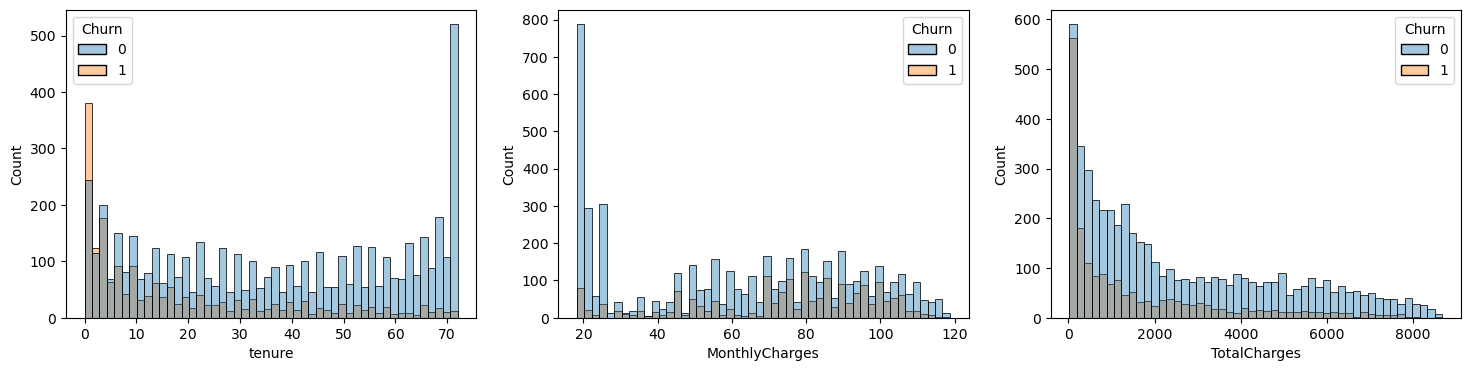

In [9]:
# Numeric feats
print(f"Numeric feats: {df.columns[df.nunique() > 2]}")

fig, ax = plt.subplots(1, 3, figsize = (18, 4))
sns.histplot(df, x = 'tenure', hue = 'Churn', bins= 50, alpha = 0.4, ax = ax[0])
sns.histplot(df, x = 'MonthlyCharges', hue = 'Churn', bins= 50, alpha = 0.4, ax = ax[1])
sns.histplot(df, x = 'TotalCharges', hue = 'Churn', bins= 50, alpha = 0.4, ax = ax[2])
plt.show()


In [10]:
for x in df.columns:
    crosstab_custom(df, x)

----- SeniorCitizen -----
   Not_churned_0  Churned_1  total churn_rate
0           4508       1393   5901      23.6%
1            666        476   1142      41.7% 

----- Partner -----
   Not_churned_0  Churned_1  total churn_rate
0           2441       1200   3641      33.0%
1           2733        669   3402      19.7% 

----- Dependents -----
   Not_churned_0  Churned_1  total churn_rate
0           3390       1543   4933      31.3%
1           1784        326   2110      15.5% 

----- PhoneService -----
   Not_churned_0  Churned_1  total churn_rate
0            512        170    682      24.9%
1           4662       1699   6361      26.7% 

----- MultipleLines -----
   Not_churned_0  Churned_1  total churn_rate
0           3053       1019   4072      25.0%
1           2121        850   2971      28.6% 

----- OnlineSecurity -----
   Not_churned_0  Churned_1  total churn_rate
0           3450       1574   5024      31.3%
1           1724        295   2019      14.6% 

----- OnlineB

In [11]:
# Features & Target
X = df.drop('Churn', axis = 1)
y = df['Churn'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77, test_size=0.2)

train = pd.concat([X_train, y_train], axis = 1)

In [12]:
for x in train.columns:
    crosstab_custom(train, x)

----- SeniorCitizen -----
   Not_churned_0  Churned_1  total churn_rate
0           3588       1113   4701      23.7%
1            544        389    933      41.7% 

----- Partner -----
   Not_churned_0  Churned_1  total churn_rate
0           1955        982   2937      33.4%
1           2177        520   2697      19.3% 

----- Dependents -----
   Not_churned_0  Churned_1  total churn_rate
0           2712       1247   3959      31.5%
1           1420        255   1675      15.2% 

----- PhoneService -----
   Not_churned_0  Churned_1  total churn_rate
0            410        141    551      25.6%
1           3722       1361   5083      26.8% 

----- MultipleLines -----
   Not_churned_0  Churned_1  total churn_rate
0           2447        832   3279      25.4%
1           1685        670   2355      28.5% 

----- OnlineSecurity -----
   Not_churned_0  Churned_1  total churn_rate
0           2734       1271   4005      31.7%
1           1398        231   1629      14.2% 

----- OnlineB

Numeric feats: Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


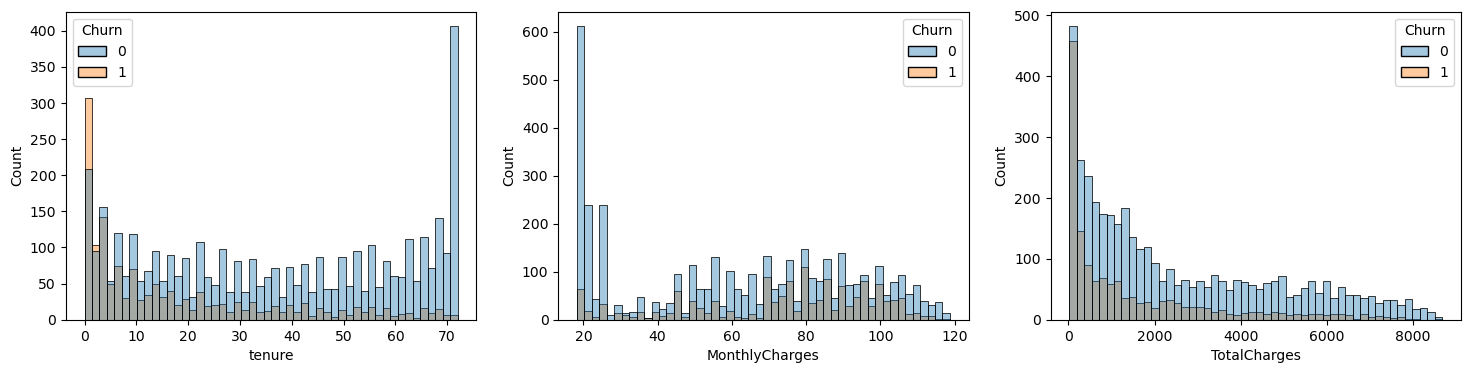

In [13]:
# Numeric feats
print(f"Numeric feats: {train.columns[train.nunique() > 2]}")

fig, ax = plt.subplots(1, 3, figsize = (18, 4))
sns.histplot(train, x = 'tenure', hue = 'Churn', bins= 50, alpha = 0.4, ax = ax[0])
sns.histplot(train, x = 'MonthlyCharges', hue = 'Churn', bins= 50, alpha = 0.4, ax = ax[1])
sns.histplot(train, x = 'TotalCharges', hue = 'Churn', bins= 50, alpha = 0.4, ax = ax[2])
plt.show()

**Notable Features** 

Industry Based Factors that would make a customer churn: 
- Subscription Price
- Tenure 
- Contract Type (Monthly)
- Customer Satisfaction for Tech Support
- Payment Method


Based on our data, these are features that are potentially predictive based on churn-rate: 
- **Senior Citizen** - Seniors are more likely to churn than non-Senior
- **Partner** - Customers with Partners have lower churn 
- **Dependents** - Similar to partners, dependents implies shared or bundled services.
- **OnlineSecurity, TechSupport** - Customers with Security and supports impacts lower churn rate *(Industry Validated)*
- **PaperlessBilling** - Suprisingly, paperless billings are more likely to churn. Our expectation is the ease of billing or payment would reduce churn and make it more convinient for customers. *(Industry Validated)*
- **Contract_Month-to-month** - Long term contracts are more likely not to churn. *(Industry Validated)*
- **InternetService_Fiber optic** - Optic users churns the most in internet type service.
- **PaymentMethod_Electronic check** - eletronic check users are more likely to churn which validates one of the factors. *(Industry Validated)*
- **Tenure** - Longer tenure's doesn't experience high churn rate. *(Industry Validated)*
- **MonthlyCharges** - Higher monthly charge experienced high churn rate. *(Industry Validated)*

### Training Loop

1. Create a model 
2. Define the loss function 
3. Define the dataset 
4. Set an optimizer
5. Run the training loop 
    - Forward Pass
    - Compute Gradients (Backpropogation)
    - Update model parameters

In [14]:
feats = ['SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'TechSupport', 'PaperlessBilling', 
         'Contract_Month-to-month', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 
         'tenure', 'MonthlyCharges']
print(len(feats))

11


#### Train, Validation, Test

In [15]:
# Features & Target
X = df.drop('Churn', axis = 1)
y = df['Churn'] 

# Train
X_train, X_test, y_train, y_test = train_test_split(X[feats], y, random_state=77, test_size = 0.20)
# Train-validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=77, test_size = 0.25)

print(f"Train: {y_train.value_counts()}")
print(f"Validation: {y_val.value_counts()}")
print(f"Test: {y_test.value_counts()}")

Train: Churn
0    3090
1    1135
Name: count, dtype: int64
Validation: Churn
0    1042
1     367
Name: count, dtype: int64
Test: Churn
0    1042
1     367
Name: count, dtype: int64


In [16]:
# To Tensors
def to_tensor(X: pd.DataFrame, y: pd.Series):
    tensor_data = TensorDataset(
                    torch.tensor(np.array(X), dtype=torch.float32), 
                    torch.tensor(np.array(y), dtype=torch.float32).reshape(-1,1)
                )
    return tensor_data

**Training loop**

In [17]:
# DataLoader  
train = to_tensor(X_train, y_train)
validation = to_tensor(X_val, y_val)
X_train_tensor, y_train_tensor = train[:]
BATCH_SIZE = 32


train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=False)


class ChurnNN(nn.Module):
    def __init__(self, input_size):
        super(ChurnNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.15)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)  # Raw logits for BCEWithLogitsLoss
        return x

# Instantiate model 
model_churn = ChurnNN(len(X_train.columns))  # -> Change for input features

# Create loss function with positive class weight (imbalance data)
pos_pct = y_train_tensor.reshape(-1).mean().unsqueeze(0)
pos_weight = (1-pos_pct)/pos_pct
loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Set optimizer
optimizer = optim.Adam(model_churn.parameters(), lr=0.001)

def train_loop(model, train_loader, validation_loader, loss_function, optimizer, epoch_size = 50):
    
    epoch_data = []
    train_loss_data = []
    validation_loss_data = []
    train_accuracy_data = []
    train_recall_data = []
    train_f1_score_data = []
    validation_accuracy_data = []
    validation_recall_data = []
    validation_f1_score_data = []

    for epoch in range(epoch_size):
        model.train()
        train_running_loss = 0.0
        y_train_true, y_train_pred = [], []

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs_train = model(inputs)
            train_loss = loss_function(outputs_train, targets)
            train_loss.backward()
            optimizer.step()
            train_running_loss += train_loss.item()
            train_probabilities = torch.sigmoid(outputs_train) 
            train_preds = (train_probabilities > 0.5).float()
            y_train_true.append(targets.numpy())
            y_train_pred.append(train_preds.numpy())
        
        y_train_true, y_train_pred = np.concatenate(y_train_true), np.concatenate(y_train_pred)
        train_acc = accuracy_score(y_train_true, y_train_pred)
        train_rec = recall_score(y_train_true, y_train_pred, pos_label=1)
        train_f1 = f1_score(y_train_true, y_train_pred, pos_label=1)

        # Update train metrics list 
        epoch_data.append(epoch)
        train_loss_data.append(train_running_loss/len(train_loader))
        train_accuracy_data.append(train_acc)
        train_recall_data.append(train_rec)
        train_f1_score_data.append(train_f1)

        # Validation
        model.eval()
        val_running_loss = 0.0
        y_val_true, y_val_pred= [], []
        with torch.inference_mode():
            for inputs, targets in validation_loader:
                outputs_val = model(inputs)
                val_running_loss += loss_function(outputs_val, targets).item()
                val_probabilities = torch.sigmoid(outputs_val) 
                val_preds = (val_probabilities >= 0.5).float()
                y_val_true.append(targets.numpy())
                y_val_pred.append(val_preds.numpy())
                
        y_val_true, y_val_pred = np.concatenate(y_val_true), np.concatenate(y_val_pred)
        val_acc = accuracy_score(y_val_true, y_val_pred)
        val_rec = recall_score(y_val_true, y_val_pred, pos_label=1)
        val_f1 = f1_score(y_val_true, y_val_pred, pos_label=1)

        # Update test metrics list 
        validation_loss_data.append(val_running_loss/len(validation_loader))
        validation_accuracy_data.append(val_acc)
        validation_recall_data.append(val_rec)
        validation_f1_score_data.append(val_f1)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epoch_size}]')
            print(f'  Train      Loss: {train_running_loss/len(train_loader):.4f} | Acc: {train_acc:.4f} | Recall (1): {train_rec:.4f} | F1 (1): {train_f1:.4f}')
            print(f'  Validation Loss: {val_running_loss/len(validation_loader):.4f} | Acc: {val_acc:.4f} | Recall (1): {val_rec:.4f} | F1 (1): {val_f1:.4f}')

    fig, ax = fig, ax = plt.subplots(2,2, figsize = (20, 10))
    # Chart one: LOSS
    sns.lineplot(x = epoch_data, y = train_loss_data, label = 'train_loss', ax = ax[0,0])
    sns.lineplot(x = epoch_data, y = validation_loss_data, label = 'validation_loss', ax = ax[0,0])
    ax[0,0].set_xlabel('EPOCH')
    ax[0,0].set_ylabel('LOSS')
    # Chart two: ACCURACY
    sns.lineplot(x = epoch_data, y = train_accuracy_data, label = 'train_accuracy', ax = ax[0,1])
    sns.lineplot(x = epoch_data, y = validation_accuracy_data, label = 'validation_accuracy', ax = ax[0,1])
    ax[0,1].set_xlabel('EPOCH')
    ax[0,1].set_ylabel('ACCURACY')
    # Chart three: RECALL
    sns.lineplot(x = epoch_data, y = train_recall_data, label = 'train_recall', ax = ax[1,0])
    sns.lineplot(x = epoch_data, y = validation_recall_data, label = 'validation_recall', ax = ax[1,0])
    ax[1,0].set_xlabel('EPOCH')
    ax[1,0].set_ylabel('RECALL')
    # Chart three: F1_SCORE
    sns.lineplot(x = epoch_data, y = train_f1_score_data, label = 'train_f1_score', ax = ax[1,1])
    sns.lineplot(x = epoch_data, y = validation_f1_score_data, label = 'validation_f1_score', ax = ax[1,1])
    ax[1,1].set_xlabel('EPOCH')
    ax[1,1].set_ylabel('F1_SCORE')
    fig.suptitle('Training Results (LOSS, ACCURACY, RECALL, F1-SCORE)')
    plt.tight_layout()
    plt.show()

    return model


Epoch [10/400]
  Train      Loss: 0.7787 | Acc: 0.7127 | Recall (1): 0.7947 | F1 (1): 0.5977
  Validation Loss: 0.7531 | Acc: 0.6742 | Recall (1): 0.8719 | F1 (1): 0.5823
Epoch [20/400]
  Train      Loss: 0.7460 | Acc: 0.7460 | Recall (1): 0.7868 | F1 (1): 0.6247
  Validation Loss: 0.7018 | Acc: 0.7630 | Recall (1): 0.7738 | F1 (1): 0.6297
Epoch [30/400]
  Train      Loss: 0.7313 | Acc: 0.7493 | Recall (1): 0.7850 | F1 (1): 0.6272
  Validation Loss: 0.7116 | Acc: 0.7842 | Recall (1): 0.7030 | F1 (1): 0.6293
Epoch [40/400]
  Train      Loss: 0.7238 | Acc: 0.7510 | Recall (1): 0.7965 | F1 (1): 0.6322
  Validation Loss: 0.6990 | Acc: 0.7473 | Recall (1): 0.7956 | F1 (1): 0.6213
Epoch [50/400]
  Train      Loss: 0.7201 | Acc: 0.7550 | Recall (1): 0.7850 | F1 (1): 0.6326
  Validation Loss: 0.6971 | Acc: 0.7665 | Recall (1): 0.7466 | F1 (1): 0.6249
Epoch [60/400]
  Train      Loss: 0.7162 | Acc: 0.7503 | Recall (1): 0.7965 | F1 (1): 0.6315
  Validation Loss: 0.6972 | Acc: 0.7608 | Recall (1)

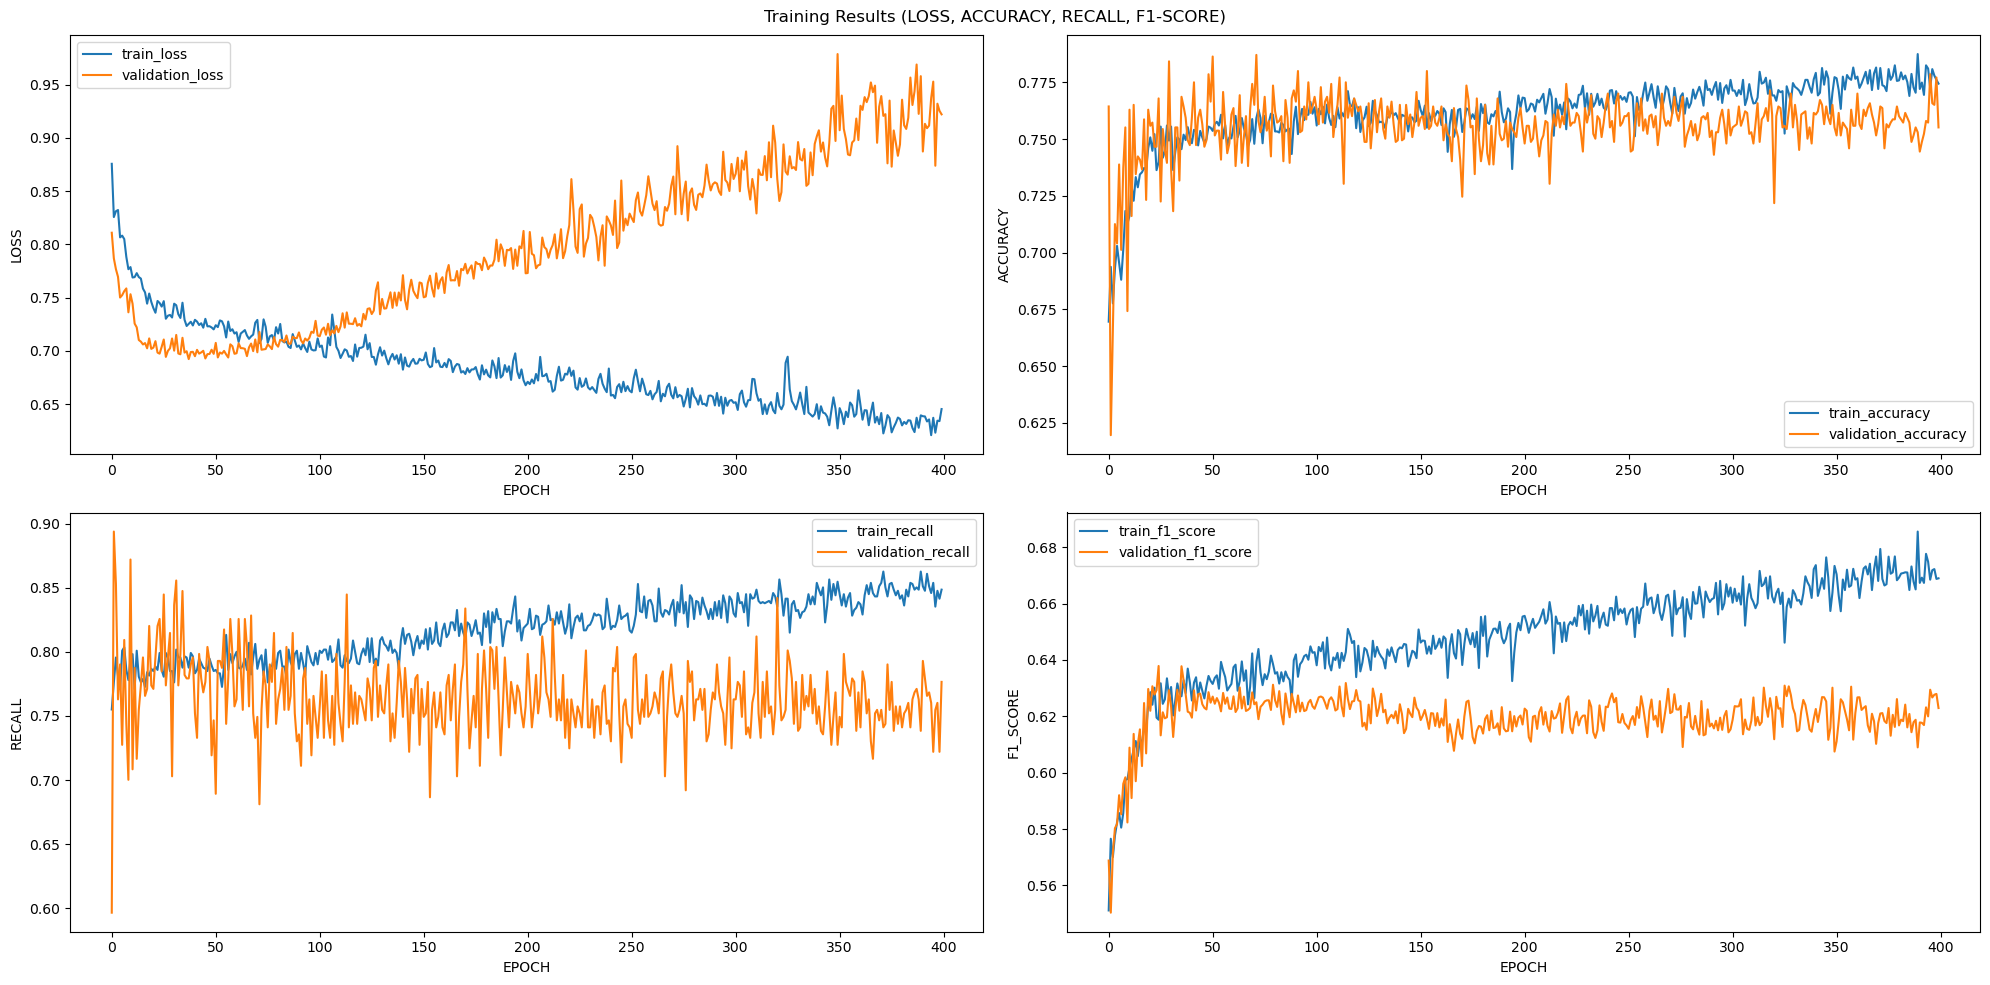

ChurnNN(
  (layer1): Linear(in_features=11, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)

In [18]:
# Training the model 
torch.manual_seed(77)
train_loop(model_churn, train_loader, validation_loader, loss_func, optimizer, 400)

*Insights:*

- It seems that the loss function stabilizes at 50th epoch together with accuracy, recall and f1-score. 
- Recall ranging from 70 to 85% at the first 100 epochs is really important for our goal to catch actual churners. 
- The model tends to overfit past 100 epochs. You can see the train and validation results difference from the loss, recall and f1-score metric.

*We will retrain the model from scratch, up to the best epoch which is around 40 and test it to our final test set.*

Epoch [10/40]
  Train      Loss: 0.7985 | Acc: 0.7164 | Recall (1): 0.8018 | F1 (1): 0.6030
  Validation Loss: 0.7345 | Acc: 0.7303 | Recall (1): 0.7520 | F1 (1): 0.5923
Epoch [20/40]
  Train      Loss: 0.7405 | Acc: 0.7404 | Recall (1): 0.7824 | F1 (1): 0.6182
  Validation Loss: 0.7469 | Acc: 0.6877 | Recall (1): 0.8638 | F1 (1): 0.5903
Epoch [30/40]
  Train      Loss: 0.7271 | Acc: 0.7555 | Recall (1): 0.7806 | F1 (1): 0.6317
  Validation Loss: 0.6984 | Acc: 0.7559 | Recall (1): 0.7820 | F1 (1): 0.6253
Epoch [40/40]
  Train      Loss: 0.7212 | Acc: 0.7598 | Recall (1): 0.7868 | F1 (1): 0.6376
  Validation Loss: 0.7052 | Acc: 0.7410 | Recall (1): 0.8311 | F1 (1): 0.6256


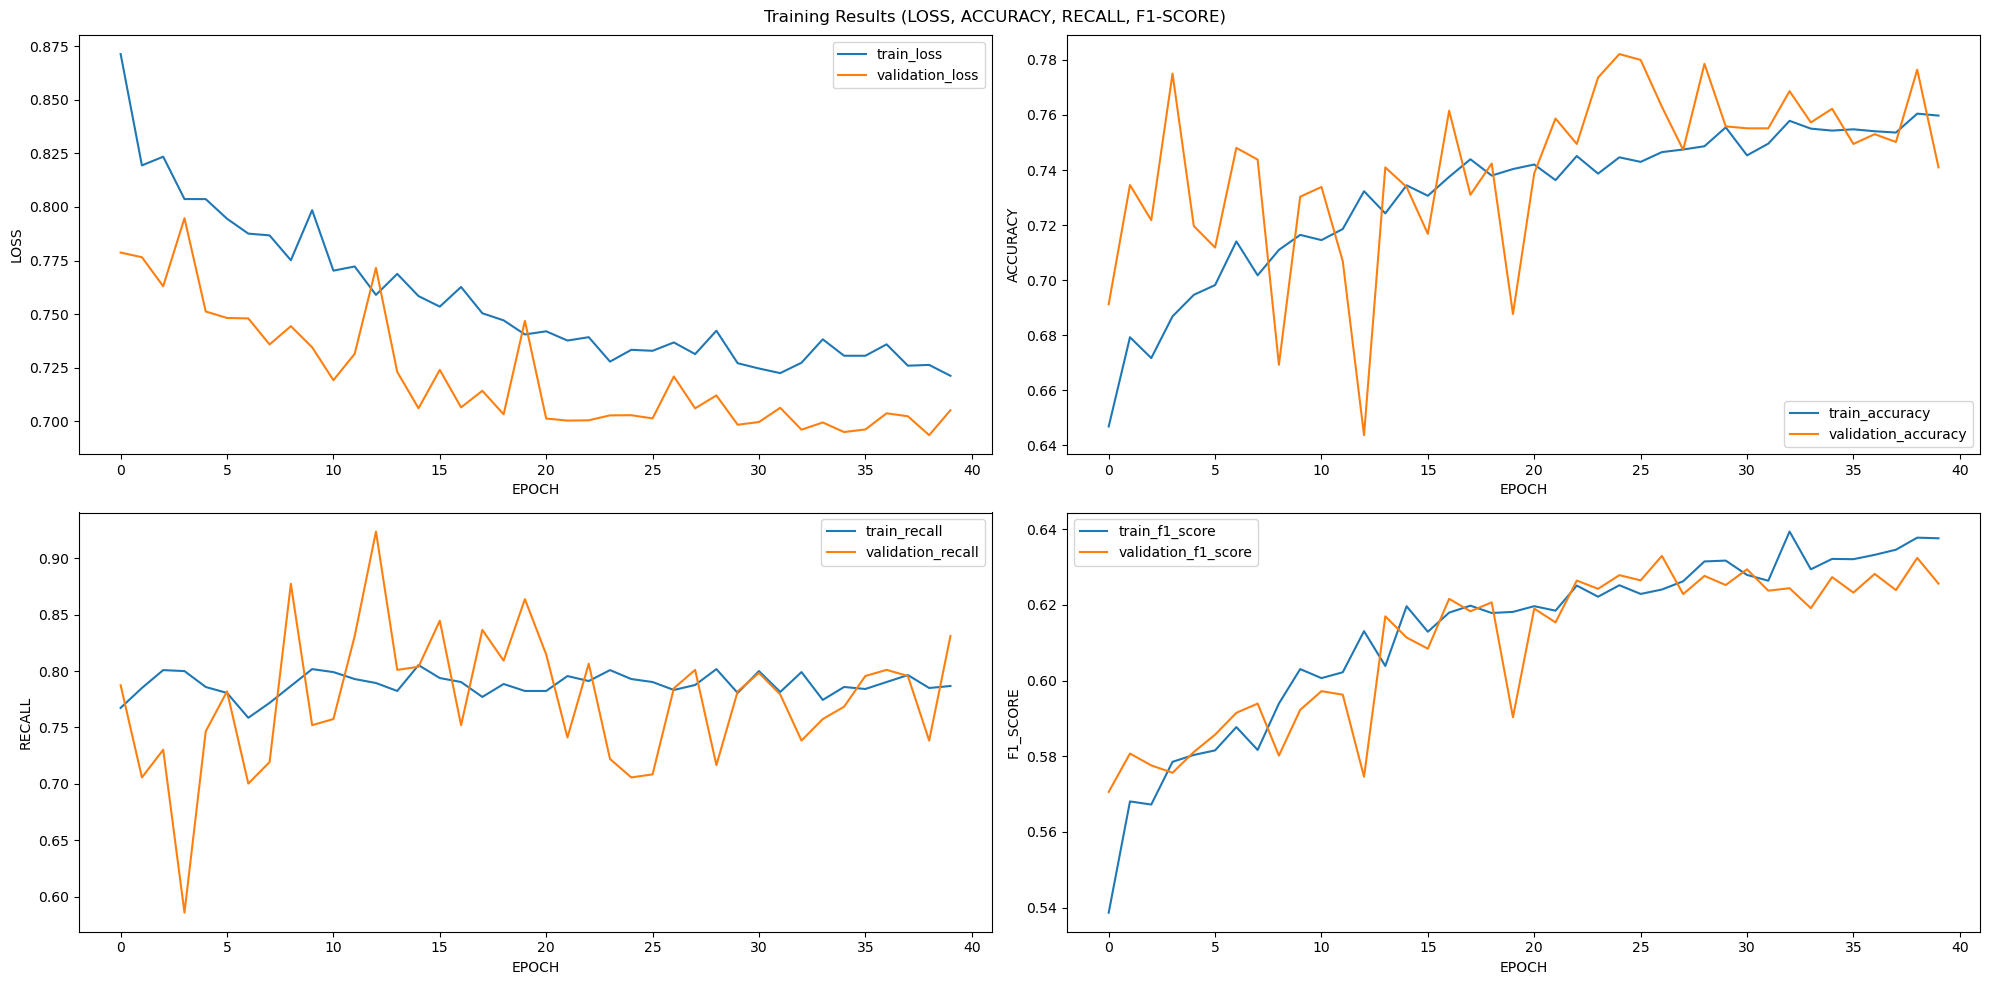

ChurnNN(
  (layer1): Linear(in_features=11, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)

In [19]:
# Retrain to appropriate EPOCH SIZE = 40
torch.manual_seed(77)

# Instantiate model 
model_churn = ChurnNN(len(X_train.columns)) 
pos_pct = y_train_tensor.reshape(-1).mean().unsqueeze(0)
pos_weight = (1-pos_pct)/pos_pct
loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# Set optimizer (AGAIN)
optimizer = optim.Adam(model_churn.parameters(), lr=0.001)

train_loop(model_churn, train_loader, validation_loader, loss_func, optimizer, 40)

**Predicting Actual Test Set**

In [20]:
# Test Data 
torch.manual_seed(77)
X_test_final = torch.tensor(np.array(X_test), dtype=torch.float32)

model_churn.eval()
with torch.inference_mode():
    y_pred_test_final = model_churn(X_test_final)
    y_pred_test_probabilities = torch.sigmoid(y_pred_test_final) 
    y_pred_test_class = (y_pred_test_probabilities >= 0.5).float()

*Evaluating Test Set Performance*

In [21]:
print("|-- METRICS TRACKED --|")
print(f"ACCURACY SCORE: {accuracy_score(y_test, y_pred_test_class.numpy()):.2f}")
print(f"F1 SCORE (churn = 1): {f1_score(y_test, y_pred_test_class.numpy(), pos_label=1):.2f}")
print(f"RECALL (churn = 1): {recall_score(y_test, y_pred_test_class.numpy(), pos_label=1):.2f}")
print('-'*60)
print(classification_report(np.array(y_test).flatten(), y_pred_test_class.numpy().flatten()))

|-- METRICS TRACKED --|
ACCURACY SCORE: 0.73
F1 SCORE (churn = 1): 0.61
RECALL (churn = 1): 0.81
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1042
           1       0.49      0.81      0.61       367

    accuracy                           0.73      1409
   macro avg       0.70      0.76      0.70      1409
weighted avg       0.80      0.73      0.75      1409



### **Business Impact Evaluation**

In [22]:
print(f"Overall average monthly revenue per user (ARPU): ${df.loc[df['Churn'] == 1, 'MonthlyCharges'].mean():.2f} USD")

Overall average monthly revenue per user (ARPU): $74.44 USD


#### Retained
*Model Recall* on Test Set: 81% 

---

Average Monthly Charge of Churners: $74.44 USD

***Retained Monthly Revenue***: 

81 users x $74.44 USD = **$6029.64 per 100 customers** 

*False Positives*

---

Our *precision* on Test Set: 49% where 51% of flagged churners *may not churn*

If it costs us $1 USD/customer for retention campaign, 

then acting on 100 flagged customers would be $100.

*False Positive Cost* = 41 users x $1 USD = 41 USD


Since we are retaining 81 churners out of 100 customers which is roughly $6029.64, we still have a good net gain. 


*Note: Tuning thresholds (0.5 currently) can be done to optimize business trade-offs*